<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/03_large_text_analysis_using_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Large text analysis using Clustering

In this notebook, we execute NLP on large collections
of real-world texts. This type of analysis is seemingly straightforward, given the
techniques presented thus far. For example, suppose we’re doing market research
across multiple online discussion forums. Each forum is composed of hundreds of
users who discuss a specific topic, such as politics, fashion, technology, or cars. We
want to automatically extract all the discussion topics based on the contents of the
user conversations. These extracted topics will be used to plan a marketing campaign,
which will target users based on their online interests.

How do we cluster user discussions into topics? 

One approach would be to do the following:
1. Convert all discussion texts into a matrix of word counts
2. Dimensionally reduce the word count matrix using singular value decomposition (SVD). This will allow us to efficiently complete all pairs of text similarities with matrix multiplication.
3. Utilize the matrix of text similarities to cluster the discussions into topics.
4. Explore the topic clusters to identify useful topics for our marketing campaign.



##Setup

In [ ]:
!pip install wordcloud

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from collections import defaultdict
from collections import Counter
import time
import numpy as np
from numpy.linalg import norm
import pandas as pd
import math
from math import sin, cos

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import binarize, normalize

from sklearn.datasets import fetch_20newsgroups

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

##20Newsgroup dataset

Usenet, which is a well-established online collection
of discussion forums, are called newsgroups. Each individual
newsgroup focuses on some topic of discussion, which is briefly outlined in the newsgroup name.

We can load these newsgroup posts by importing `fetch_20newsgroups` from `sklearn.datasets`.

In [4]:
# Fetching the newsgroup dataset
newsgroups = fetch_20newsgroups(remove=("headers", "footers"))

The newsgroups object contains posts from 20 different newsgroups.

In [5]:
# Printing the names of all 20 newsgroups
print(newsgroups.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
print(len(newsgroups.target_names))

20


Now, let’s turn our attention to the actual newsgroup texts, which are stored as a list in the newsgroups.data attribute.

In [7]:
# Printing the first newsgroup post
print(newsgroups.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [8]:
# Printing the newsgroup name at index 0
origin = newsgroups.target_names[newsgroups.target[0]]
print(f"The post at index 0 first appeared in the '{origin}' group.")

The post at index 0 first appeared in the 'rec.autos' group.


Let’s dive deeper into our newsgroup dataset by printing out the dataset size.

In [9]:
# Counting the number of newsgroup posts
dataset_size = len(newsgroups.data)
print(f"Our dataset contains {dataset_size} newsgroup posts")

Our dataset contains 11314 newsgroup posts


##Vectorizing documents

We need
to efficiently compute newsgroup post similarities by representing our text data as a
matrix. 

To do so, we need to transform each newsgroup post into a term-frequency
(TF) vector.

Scikit-learn provides a `CountVectorizer` class for transforming input texts into TF vectors.

In [10]:
# Computing a TF matrix
vectorizer = CountVectorizer()
tf_matrix = vectorizer.fit_transform(newsgroups.data)
print(tf_matrix)

  (0, 108644)	4
  (0, 110106)	1
  (0, 57577)	2
  (0, 24398)	2
  (0, 79534)	1
  (0, 100942)	1
  (0, 37154)	1
  (0, 45141)	1
  (0, 70570)	1
  (0, 78701)	2
  (0, 101084)	4
  (0, 32499)	4
  (0, 92157)	1
  (0, 100827)	6
  (0, 79461)	1
  (0, 39275)	1
  (0, 60326)	2
  (0, 42332)	1
  (0, 96432)	1
  (0, 67137)	1
  (0, 101732)	1
  (0, 27703)	1
  (0, 49871)	2
  (0, 65338)	1
  (0, 14106)	1
  :	:
  (11313, 55901)	1
  (11313, 93448)	1
  (11313, 97535)	1
  (11313, 93393)	1
  (11313, 109366)	1
  (11313, 102215)	1
  (11313, 29148)	1
  (11313, 26901)	1
  (11313, 94401)	1
  (11313, 89686)	1
  (11313, 80827)	1
  (11313, 72219)	1
  (11313, 32984)	1
  (11313, 82912)	1
  (11313, 99934)	1
  (11313, 96505)	1
  (11313, 72102)	1
  (11313, 32981)	1
  (11313, 82692)	1
  (11313, 101854)	1
  (11313, 66399)	1
  (11313, 63405)	1
  (11313, 61366)	1
  (11313, 7462)	1
  (11313, 109600)	1


In [11]:
# Checking the data type
print(type(tf_matrix))

<class 'scipy.sparse.csr.csr_matrix'>


In [12]:
# Converting a CSR matrix to a NumPy array
tf_np_matrix = tf_matrix.toarray()
print(tf_np_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Checking the vocabulary size
assert tf_np_matrix.shape == tf_matrix.shape
num_posts, vocabulary_size = tf_np_matrix.shape
print(f"Our collection of {num_posts} newsgroup posts contain a total of {vocabulary_size} unique words")

Our collection of 11314 newsgroup posts contain a total of 114751 unique words


In [14]:
# Counting the unique words in the car post
tf_vector = tf_np_matrix[0]
non_zero_indices = np.flatnonzero(tf_vector)
num_unique_words = non_zero_indices.size

print(f"The newsgroup in row 0 contains {num_unique_words} unique words.")
print("The actual word counts map to the following column indices:\n")
print(non_zero_indices)

The newsgroup in row 0 contains 64 unique words.
The actual word counts map to the following column indices:

[ 14106  15549  22088  23323  24398  27703  29357  30093  30629  32194
  32305  32499  37154  39275  42332  42333  43643  45089  45141  49871
  49881  50165  54442  55453  57577  58321  58842  60116  60326  64083
  65338  67137  67140  68931  69080  70570  72915  75280  78264  78701
  79055  79461  79534  82759  84398  87690  89161  92157  93304  95225
  96145  96432 100406 100827 100942 101084 101732 108644 109086 109254
 109294 110106 112936 113262]


Let's find a mapping between TF vector indices and word values.

In [15]:
# Printing the unique words in the car post
words = vectorizer.get_feature_names()
unique_words = [words[i] for i in non_zero_indices]
print(unique_words)

['60s', '70s', 'addition', 'all', 'anyone', 'be', 'body', 'bricklin', 'bumper', 'called', 'can', 'car', 'could', 'day', 'door', 'doors', 'early', 'engine', 'enlighten', 'from', 'front', 'funky', 'have', 'history', 'if', 'in', 'info', 'is', 'it', 'know', 'late', 'looked', 'looking', 'made', 'mail', 'me', 'model', 'name', 'of', 'on', 'or', 'other', 'out', 'please', 'production', 'really', 'rest', 'saw', 'separate', 'small', 'specs', 'sports', 'tellme', 'the', 'there', 'this', 'to', 'was', 'were', 'whatever', 'where', 'wondering', 'years', 'you']


In [16]:
# confirming first and last word
print(words[14106])
print(words[113262])

60s
you


In [17]:
# Printing the most frequent words in the car post
data = {"Word": unique_words, "Count": tf_vector[non_zero_indices]}
df = pd.DataFrame(data).sort_values("Count", ascending=False)
print(df[:10].to_string(index=False))

  Word  Count
   the      6
  this      4
   was      4
   car      4
    if      2
    is      2
    it      2
  from      2
    on      2
anyone      2


In [18]:
# free memory
del tf_matrix
del tf_np_matrix
del tf_vector

The common words are a source of noise and increase the likelihood
that two unrelated documents will cluster together. 

NLP practitioners refer to
such noisy words as stop words because they are blocked from appearing in the vectorized
results. 

Stop words are generally deleted from the text before vectorization.

In [19]:
# Removing stop words during vectorization
vectorizer = CountVectorizer(stop_words="english")
tf_matrix = vectorizer.fit_transform(newsgroups.data)
assert tf_matrix.shape[1] < 114751 

# Common stop words have been filtered out
words = vectorizer.get_feature_names()
for common_word in ["the", "this", "is", "was", "if", "it", "on"]:
  assert common_word not in words

In [20]:
# Reprinting the top words after stop-word deletion
tf_np_matrix = tf_matrix.toarray()
tf_vector = tf_np_matrix[0]
non_zero_indices = np.flatnonzero(tf_vector)
unique_words = [words[i] for i in non_zero_indices]

data = {"Word": unique_words, "Count": tf_vector[non_zero_indices]}
df = pd.DataFrame(data).sort_values("Count", ascending=False)
print(f"After stop-word deletion, {df.shape[0]} unique words remain.")
print(f"The 10 most frequent words are:\n")
print(df[:10].to_string(index=False))

After stop-word deletion, 34 unique words remain.
The 10 most frequent words are:

      Word  Count
       car      4
       60s      1
       saw      1
   looking      1
      mail      1
     model      1
production      1
    really      1
      rest      1
  separate      1


##Ranking words

Each of the 34 words in df.Word appears in a certain fraction of newsgroup posts. In
NLP, this fraction is referred to as the document frequency of a word. 

We hypothesize
that the document frequencies can improve our word rankings.

We can compute these frequencies
using a series of NumPy matrix manipulations.

In [21]:
# Filtering matrix columns with non_zero_indices
sub_matrix = tf_np_matrix[:, non_zero_indices]
print("Our sub-matrix corresponds to the 34 words within post 0.\nThe first row of the sub-matrix is:")
print(sub_matrix[0])

Our sub-matrix corresponds to the 34 words within post 0.
The first row of the sub-matrix is:
[1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


However, we are not currently interested
in exact word counts: we just want to know whether each word is present or
absent from each post. 

So, we need to convert our counts into binary values.

In [22]:
# Converting word counts to binary values
binary_matrix = binarize(sub_matrix)
print(binary_matrix)

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Now we need to add together the rows of our binary submatrix. 

Doing so will produce
a vector of integer counts.

In [23]:
# Summing matrix rows to obtain post counts
unique_post_mentions = binary_matrix.sum(axis=0)
print(f"This vector counts the unique posts in which each word is mentioned:\n {unique_post_mentions}")

This vector counts the unique posts in which each word is mentioned:
 [  18   21  202  314    4   26  802  536  842  154   67  348  184   25
    7  368  469 3093  238  268  780  901  292   95 1493  407  354  158
  574   95   98    2  295 1174]


In [24]:
# Computing post mention counts in a single line of code
np_post_mentions = binarize(tf_np_matrix[:, non_zero_indices]).sum(axis=0)
csr_post_mentions = binarize(tf_matrix[:, non_zero_indices]).sum(axis=0)

print(f"f'NumPy matrix-generated counts:\n {np_post_mentions}\n")
print(f"CSR matrix-generated counts:\n {csr_post_mentions}")

f'NumPy matrix-generated counts:
 [  18   21  202  314    4   26  802  536  842  154   67  348  184   25
    7  368  469 3093  238  268  780  901  292   95 1493  407  354  158
  574   95   98    2  295 1174]

CSR matrix-generated counts:
 [[  18   21  202  314    4   26  802  536  842  154   67  348  184   25
     7  368  469 3093  238  268  780  901  292   95 1493  407  354  158
   574   95   98    2  295 1174]]


The numbers in `np_post_mentions` and `csr_post_mentions` appear identical.

Let’s transform
these counts into document frequencies and align the frequencies with `df.Word`.

In [25]:
# Printing the words with the highest document frequency
document_frequencies = unique_post_mentions / dataset_size
data = {"Word": unique_words, "Count": tf_vector[non_zero_indices], "DF": document_frequencies}

df = pd.DataFrame(data)
# choose words with a document frequency greater than 1/10
df_common_words = df[df["DF"] >= .1]
print(df_common_words.to_string(index=False))

  Word  Count       DF
  know      1 0.273378
really      1 0.131960
 years      1 0.103765


As expected, these words are very general and not car specific. We thus can utilize document frequencies for ranking purposes.

Let’s rank our words by relevance in the following
manner. First, we sort the words by count, from greatest to smallest. 

Then, all words
with equal count are sorted by document frequency, from smallest to greatest.

In [26]:
# Ranking words by both count and document frequency
df_sorted = df.sort_values(["Count", "DF"], ascending=[False, True])
print(df_sorted[:10].to_string(index=False))

      Word  Count       DF
       car      4 0.047375
    tellme      1 0.000177
  bricklin      1 0.000354
     funky      1 0.000619
       60s      1 0.001591
       70s      1 0.001856
 enlighten      1 0.002210
    bumper      1 0.002298
     doors      1 0.005922
production      1 0.008397


Our sorting was successful. New car-related words, such as bumper, are now present in
our list of top-ranked words.

However, the actual sorting procedure was rather convoluted:
it required us to sort two columns separately. 

Perhaps we can simplify the process
by combining the word counts and document frequencies into a single score.

How can we do this? 

One approach is to divide each word count by its associated document
frequency. 

The resulting value will increase if either of the following is true:
* The word count goes up.
* The document frequency goes down.

Let’s combine the word counts and the document frequencies into a single score. We
start by computing 1 / document_frequencies. 

Doing so produces an array of inverse
document frequencies (IDFs). 

Next, we multiply df.Count by the IDF array to compute
the combined score.

In [27]:
# Combining counts and frequencies into a single score
inverse_document_frequencies = 1 / document_frequencies
df["IDF"] = inverse_document_frequencies
df["Combined"] = df.Count * inverse_document_frequencies
df_sorted = df.sort_values("Combined", ascending=False)
print(df_sorted[:10].to_string(index=False))

      Word  Count       DF         IDF    Combined
    tellme      1 0.000177 5657.000000 5657.000000
  bricklin      1 0.000354 2828.500000 2828.500000
     funky      1 0.000619 1616.285714 1616.285714
       60s      1 0.001591  628.555556  628.555556
       70s      1 0.001856  538.761905  538.761905
 enlighten      1 0.002210  452.560000  452.560000
    bumper      1 0.002298  435.153846  435.153846
     doors      1 0.005922  168.865672  168.865672
     specs      1 0.008397  119.094737  119.094737
production      1 0.008397  119.094737  119.094737


Our new ranking failed! The word car no longer appears at the top of the list.

There is a problem with the IDF values: some of them are huge!

Meanwhile, our word-count range is very small: from 1 to 4. 

Thus, when we multiply
word counts by IDF values, the IDF dominates, and the counts have no impact on the final results. We need to somehow make our IDF values smaller. 

What should we do?

Data scientists are commonly confronted with numeric values that are too large.

**One way to shrink the values is to apply a logarithmic function.**

In [28]:
# Shrinking a large value using its logarithm
assert np.log10(1000000) == 6
assert np.log10(10000) == 4
assert np.log10(100) == 2
assert np.log10(10) == 1
assert np.log10(1) == 0
assert np.log10(0) == -np.inf
assert math.isnan(np.log10(-1)) == math.isnan(float('nan'))

Let’s recompute our ranking score.

In [29]:
# Adjusting the combined score using logarithms
df["Combined"] = df.Count * np.log10(df.IDF)
df_sorted = df.sort_values("Combined", ascending=False)
print(df_sorted[:10].to_string(index=False))

     Word  Count       DF         IDF  Combined
      car      4 0.047375   21.108209  5.297806
   tellme      1 0.000177 5657.000000  3.752586
 bricklin      1 0.000354 2828.500000  3.451556
    funky      1 0.000619 1616.285714  3.208518
      60s      1 0.001591  628.555556  2.798344
      70s      1 0.001856  538.761905  2.731397
enlighten      1 0.002210  452.560000  2.655676
   bumper      1 0.002298  435.153846  2.638643
    doors      1 0.005922  168.865672  2.227541
    specs      1 0.008397  119.094737  2.075893


Our adjusted ranking score has yielded good results. The word car is once again present
at the top of the ranked list. 

Also, bumper still appears among the top 10 ranked
words. Meanwhile, really is missing from the list.

**Our effective score is called the term frequency-inverse document frequency (TFIDF)**.

The TFIDF can be computed by taking the product of the TF (word count) and the
log of the IDF.

Mathematically, $np.log(1 / x)$ is equal to $-np.log(x)$. 

Therefore, we
can compute the TFIDF directly from the document frequencies.

In [30]:
df["Combined"] = df.Count * -np.log10(document_frequencies)
df_sorted = df.sort_values("Combined", ascending=False)
print(df_sorted[:10].to_string(index=False))

     Word  Count       DF         IDF  Combined
      car      4 0.047375   21.108209  5.297806
   tellme      1 0.000177 5657.000000  3.752586
 bricklin      1 0.000354 2828.500000  3.451556
    funky      1 0.000619 1616.285714  3.208518
      60s      1 0.001591  628.555556  2.798344
      70s      1 0.001856  538.761905  2.731397
enlighten      1 0.002210  452.560000  2.655676
   bumper      1 0.002298  435.153846  2.638643
    doors      1 0.005922  168.865672  2.227541
    specs      1 0.008397  119.094737  2.075893


The TFIDF is a simple but powerful metric for ranking words in a document. Of
course, the metric is only relevant if that document is part of a larger document group. 

Otherwise, the computed TFIDF values all equal zero.

And it has
additional uses: it can be utilized to vectorize words in a document.

In this same manner, we can transform any TF vector into a
TFIDF vector. We just need to multiply the TF vector by the log of inverse document frequencies.

Is there a benefit to transforming TF vectors into more complicated TFIDF vectors?

Yes! In larger text datasets, TFIDF vectors provide a greater signal of textual similarity
and divergence.

For example, two texts that are both discussing cars are more
likely to cluster together if their irrelevant vector elements are penalized.

Thus, **penalizing common words using the IDF improves the clustering of large text collections.**

We therefore stand to gain by transforming our TF matrix into a TFIDF matrix.

In [31]:
# free memory
del tf_matrix
del tf_np_matrix
del tf_vector

##Computing TF-IDF vectors

That `TfidfVectorizer` class is nearly identical to `CountVectorizer`, except that it
takes IDF into account during the vectorization process.

In [32]:
# Computing a TFIDF matrix with scikit-learn
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(newsgroups.data)

#assert tfidf_matrix.shape == tf_matrix.shape

In [33]:
# Confirming the preservation of vectorized word indices
assert tfidf_vectorizer.get_feature_names() == words

Since word order is preserved, we should expect the nonzero indices of `tfidf_
matrix[0]` to equal our previously computed `non_zero_indices` array.

In [34]:
# Confirming the preservation of nonzero indices
tfidf_np_matrix = tfidf_matrix.toarray()
tfidf_vector = tfidf_np_matrix[0]
tfidf_non_zero_indices = np.flatnonzero(tfidf_vector)

# The nonzero indices of tf_vector and tfidf_vector are identical.
assert np.array_equal(tfidf_non_zero_indices, non_zero_indices)

In [35]:
# Adding a TFIDF vector to the existing Pandas table
df["TF-IDF"] = tfidf_vector[non_zero_indices]

Sorting by `df.TF-IDF` should produce a relevance ranking that is consistent with our
previous observations. 

Let’s verify that both `df.TF-IDF` and `df.Combined` produce the
same word rankings after sorting.

In [36]:
# Sorting words by df.TFIDF
df_sorted_old = df.sort_values("Combined", ascending=False)
df_sorted_new = df.sort_values("TF-IDF", ascending=False)

assert np.array_equal(df_sorted_old["Word"].values, df_sorted_new["Word"].values)

print(df_sorted_new[:10].to_string(index=False))

     Word  Count       DF         IDF  Combined   TF-IDF
      car      4 0.047375   21.108209  5.297806 0.459552
   tellme      1 0.000177 5657.000000  3.752586 0.262118
 bricklin      1 0.000354 2828.500000  3.451556 0.247619
    funky      1 0.000619 1616.285714  3.208518 0.234280
      60s      1 0.001591  628.555556  2.798344 0.209729
      70s      1 0.001856  538.761905  2.731397 0.205568
enlighten      1 0.002210  452.560000  2.655676 0.200827
   bumper      1 0.002298  435.153846  2.638643 0.199756
    doors      1 0.005922  168.865672  2.227541 0.173540
    specs      1 0.008397  119.094737  2.075893 0.163752


Our word rankings have remained unchanged. However, the values of the `TF-IDF` and `Combined` columns are not identical.

Why is this the case?

As it turns out, scikit-learn automatically normalizes its `TFIDF` vector results. 

The magnitude of `df.TF-IDF` has been modified to equal 1. 

We can confirm by calling
`norm(df.TFIDF.values)`.

In [37]:
# Confirming that our TFIDF vector is normalized
assert norm(df["TF-IDF"].values) == 1

Why would scikit-learn automatically normalize the vectors?

As discussed, it’s easier to compute text vector similarity when all vector
magnitudes equal 1. 

Consequently, our normalized TFIDF matrix is primed for similarity analysis.

>To turn off normalization, we must pass `norm=None` into the vectorizer’s
initialization function. Running `TfidfVectorizer(norm=None, stop_
words='english')` returns a vectorizer in which normalization has been
deactivated.

##Computing document similarities

Let’s answer a simple question: 

which of our newsgroup posts is most similar to `newsgroups.post[0]`?

We can get the answer by computing all the cosine similarities
between `tfidf_np_matrix` and `tfidf_np_matrix[0]`.

The simple multiplication between the matrix and the vector is sufficient
because all rows in the matrix have a magnitude of 1.

In [38]:
# Computing similarities to a single newsgroup post
cosine_similarities = tfidf_np_matrix @ tfidf_np_matrix[0]
print(cosine_similarities)

[1.         0.00834093 0.04448717 ... 0.         0.00270615 0.01968562]


From the printout, we can see that `cosine_similarities[0]` is equal to 1.0. 

This is not surprising since `newsgroups_data[0]` will have a perfect similarity with itself.

What is the next-highest similarity in the vector?

The argsort call sorts the array indices by their ascending values. 

So, the second-tolast
index will correspond to the post with the second-highest similarity.

In [39]:
# Finding the most similar newsgroup post
most_similar_index = np.argsort(cosine_similarities)[-2]
similarity = cosine_similarities[most_similar_index]
most_similar_post = newsgroups.data[most_similar_index]

print(f"The following post has a cosine similarity of {similarity:.2f} with newsgroups.data[0]:\n")
print("-"*100)
print(most_similar_post)
print("-"*100)
print(newsgroups.data[0])

The following post has a cosine similarity of 0.64 with newsgroups.data[0]:

----------------------------------------------------------------------------------------------------
In article <1993Apr20.174246.14375@wam.umd.edu> lerxst@wam.umd.edu (where's my  
thing) writes:
> 
>  I was wondering if anyone out there could enlighten me on this car I saw
> the other day. It was a 2-door sports car, looked to be from the late 60s/
> early 70s. It was called a Bricklin. The doors were really small. In  
addition,
> the front bumper was separate from the rest of the body. This is 
> all I know. If anyone can tellme a model name, engine specs, years
> of production, where this car is made, history, or whatever info you
> have on this funky looking car, please e-mail.

Bricklins were manufactured in the 70s with engines from Ford. They are rather  
odd looking with the encased front bumper. There aren't a lot of them around,  
but Hemmings (Motor News) ususally has ten or so listed. Basically, 

The printed text is a reply to the car post at index 0.

Due to textual overlap, both the original
post and the reply are very similar to each other. Their cosine similarity is 0.64, which does not seem like a large number.

Let’s extend our analysis to another post. We’ll pick a newsgroup post at random, choose its most similar neighbor, and then output both posts, along with their cosine similarity. 

To make this exercise
more interesting, we’ll first compute a matrix of all-by-all cosine similarities. We’ll
then use the matrix to select our random pair of similar posts.

How do we compute the matrix of all-by-all cosine similarities?

The naive approach is to multiply tfidf_np_matrix with its transpose. 

However, this matrix multiplication is not computationally efficient. Our TFIDF matrix
has over 100,000 columns. We need to reduce the matrix size before executing the multiplication.

In [40]:
# Dimensionally reducing tfidf_matrix using SVD
np.random.seed(0)

shrunk_matrix = TruncatedSVD(n_components=100).fit_transform(tfidf_matrix)
print(f"We've dimensionally reduced a {tfidf_matrix.shape[1]}-column {type(tfidf_matrix)} matrix")
print(f"Our output is a {shrunk_matrix.shape[1]}-column {type(shrunk_matrix)} matrix")

We've dimensionally reduced a 114441-column <class 'scipy.sparse.csr.csr_matrix'> matrix
Our output is a 100-column <class 'numpy.ndarray'> matrix


We can now efficiently compute the
cosine similarities by running `shrunk_matrix @ shrunk_matrix.T`. 

However, first we
need to confirm that the matrix rows remain normalized.

In [41]:
# Checking the magnitude of shrunk_matrix[0]
magnitude = norm(shrunk_matrix[0])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 0.49


The magnitude of the row is less than 1.

We need to manually normalize the matrix before computing
the similarities.

In [42]:
# Normalizing the SVD output
shrunk_norm_matrix = normalize(shrunk_matrix)
magnitude = norm(shrunk_norm_matrix[0])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 1.00


In [43]:
# free memory
del shrunk_matrix

# Computing all-by-all cosine similarities
cosine_similarity_matrix = shrunk_norm_matrix @ shrunk_norm_matrix.T

In [44]:
# free memory
# del shrunk_norm_matrix

Let’s use it to choose a random pair of very similar
texts.

In [45]:
# Choosing a random pair of similar posts
np.random.seed(1)

index1 = np.random.randint(dataset_size)
index2 = np.argsort(cosine_similarity_matrix[index1])[-2]
similarity = cosine_similarity_matrix[index1][index2]

print(f"The posts at indices {index1} and {index2} share a cosine similarity of {similarity:.2f}")

The posts at indices 235 and 7805 share a cosine similarity of 0.91


In [46]:
# Printing a randomly chosen post
print(newsgroups.data[index2].replace("\n\n", "\n"))

Hello,
	Who can tell me   Where can I find the PD or ShareWare   
Which can CAPTURE windows 3.1's output of printer mananger?
	I want to capture the output of HP Laser Jet III.
	Though the PostScript can setup to print to file,but HP can't.
	I try DOS's redirect program,but they can't work in Windows 3.1
		Thankx for any help....
--
 Internet Address: u7911093@cc.nctu.edu.tw
    English Name: Erik Wang
    Chinese Name: Wang Jyh-Shyang


Once again, the printed post is a question. 

It’s safe to assume that the post at `index1` is
an answer to that question.

In [47]:
# Printing the most similar post response
print(newsgroups.data[index1].replace("\n\n", "\n"))

u7911093@cc.nctu.edu.tw ("By SWH ) writes:
>Who can tell me which program (PD or ShareWare) can redirect windows 3.1's
>output of printer manager to file? 
>	I want to capture HP Laser Jet III's print output.
> 	Though PostScript can setup print to file,but HP can't.
>	I use DOS's redirect program,but they can't work in windows.
>		Thankx for any help...
>--
> Internet Address: u7911093@cc.nctu.edu.tw
>    English Name: Erik Wang
>    Chinese Name: Wang Jyh-Shyang
> National Chiao-Tung University,Taiwan,R.O.C.
Try setting up another HPIII printer but when choosing what port to connect it
to choose FILE instead of like :LPT1.  This will prompt you for a file name
everytime you print with that "HPIII on FILE" printer. Good Luck.



Thus far, we have examined two pairs of similar posts. Each post pair was composed of
a question and a reply, where the question was included in the reply. Such boring
pairs of overlapping texts are trivial to extract.

##Clustering texts by topic

Let’s challenge ourselves to find something
more interesting. 

We’ll search for clusters of similar texts where posts in a cluster
share some text without perfectly overlapping.

K-means can only cluster on Euclidean distance. Conversely, DBSCAN can cluster based on any distance metric.

Cosine distance is commonly used in conjunction with DBSCAN.

Let’s cluster `shrunk_matrix` with DBSCAN based on cosine distance. 

During clustering,
we will make the following reasonable assumptions:

* Two newsgroup posts fall in a cluster if they share a cosine similarity of at least 0.6 (which corresponds to a cosine distance of no greater than 0.4).
* A cluster contains at least 50 newsgroup posts.

```python
# Clustering newsgroup posts with DBSCAN
cluster_model = DBSCAN(eps=0.4, min_samples=50, metric="cosine")
clusters = cluster_model.fit_predict(shrunk_matrix)
```


We already know that the newsgroups dataset covers 20 newsgroup categories.

Thus, it’s reasonable to assume that the dataset covers 10 to 25 truly diverging topics.

Consequently, we can expect our clusters array to contain somewhere between 10
and 25 clusters—otherwise, there’s something wrong with our input clustering parameters.

```python
# Counting the number of DBSCAN clusters
cluster_count = clusters.max() + 1
print(f"We have generated {cluster_count} DBSCAN clusters")
```

```log
 We've generated 3 DBSCAN clusters
 ```

We’ve generated just three clusters, which is way lower than our expected cluster count. Clearly, our DBSCAN parameters were wrong.

Is there some algorithmic
method to adjust these parameters accordingly?

Sadly, no.

Unfortunately, DBSCAN lacks a well-established algorithm for optimizing these two crucial parameters.

K-means, on the other hand, takes as input a single $K$ parameter. We can estimate $K$ using the elbow plot technique.

However, the
K-means algorithm can only cluster based on Euclidean distance: it cannot process cosine distance. 

Is this a problem? Not necessarily. 

As it happens, we’re in luck! All
rows in `shrunk_norm_matrix` are normalized unit vectors.

With basic algebra, we can easily show that the Euclidean distance of two normalized vectors is proportional to the square root of the cosine distance. 

The two distance metrics are very closely related! This relationship provides us with mathematical justification
for clustering `shrunk_norm_matrix` using K-means.

However, we face a problem. Our dataset is large, containing over 10,000 points.
The scikit-learn KMeans implementation will take a second or two to cluster the data.
That lag time is acceptable for a single clustering run, but it’s not acceptable for 60
different runs, where the execution time may add up to multiple minutes. 

How can we speed up the K-means running time?

At no point will we need to analyze the full dataset all at
once. This modified version of the K-means algorithm is known as mini-batch K-means.



In [48]:
# Comparing KMeans to MiniBatchKMeans
np.random.seed(0)

k = 20
times = []
for KMeans_class in [KMeans, MiniBatchKMeans]:
  start_time = time.time()
  KMeans_class(k).fit(shrunk_norm_matrix)
  times.append(time.time() - start_time)

running_time_ratio = times[0] / times[1]
print(f"Mini Batch K-means ran {running_time_ratio:.2f} times faster than regular K-means")

Mini Batch K-means ran 10.59 times faster than regular K-means


`MiniBatchKMeans` runs approximately 10 times faster than regular `KMeans`.

We now generate the plot using mini-batch K-means.

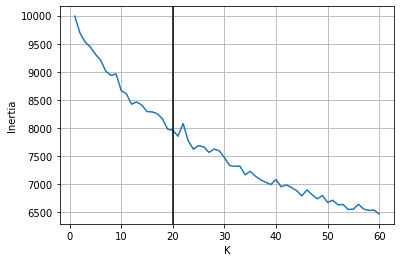

In [49]:
# Plotting an elbow curve using MiniBatchKMeans
np.random.seed(0)

k_values = range(1, 61)
inertia_values = [MiniBatchKMeans(k).fit(shrunk_norm_matrix).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.axvline(20, c="k")
plt.grid(True)
plt.show()

Our plotted curve decreases smoothly. The precise location of a bent elbow–shaped
transition is difficult to spot.

We will now divide `shrunk_norm_matrix` into 20 clusters.

In [50]:
# Clustering newsgroup posts into 20 clusters
np.random.seed(0)

cluster_model = KMeans(n_clusters=20)
clusters = cluster_model.fit_predict(shrunk_norm_matrix)
df = pd.DataFrame({"Index": range(clusters.size), "Cluster": clusters})

We have clustered our texts and are ready to explore the cluster contents.

##Exploring a single text cluster

With this in mind, let’s proceed with the analysis. We begin by analyzing a single cluster. 

Later, we analyze all the clusters simultaneously.

One of our 20 clusters contains the car post at index 0 of `newsgroups.data`. 

Let’s isolate and count the number of texts that group together.

In [51]:
# Isolating the car cluster
df_car = df[df.Cluster == clusters[0]]
cluster_size = df_car.shape[0]
print(f"{cluster_size} posts cluster together with the car-themed post at index 0")

409 posts cluster together with the car-themed post at index 0


Presumably, these posts are also
about cars. 

If so, then a randomly chosen post should mention an automobile. 

Let’s verify if this is the case.

In [52]:
# Printing a random post in the car cluster
np.random.seed(1)

def get_post_category(index):
  target_index = newsgroups.target[index]
  return newsgroups.target_names[target_index]

random_index = np.random.choice(df_car.Index.values)
post_category = get_post_category(random_index)

print(f"This post appeared in the {post_category} discussion group:\n")
print(newsgroups.data[random_index].replace("\n\n", "\n"))

This post appeared in the rec.autos discussion group:

In article <1993Apr20.174246.14375@wam.umd.edu> lerxst@wam.umd.edu (where's my  
thing) writes:
> 
>  I was wondering if anyone out there could enlighten me on this car I saw
> the other day. It was a 2-door sports car, looked to be from the late 60s/
> early 70s. It was called a Bricklin. The doors were really small. In  
addition,
> the front bumper was separate from the rest of the body. This is 
> all I know. If anyone can tellme a model name, engine specs, years
> of production, where this car is made, history, or whatever info you
> have on this funky looking car, please e-mail.
Bricklins were manufactured in the 70s with engines from Ford. They are rather  
odd looking with the encased front bumper. There aren't a lot of them around,  
but Hemmings (Motor News) ususally has ten or so listed. Basically, they are a  
performance Ford with new styling slapped on top.
>    ---- brought to you by your neighborhood Lerxst ----
Rus

How many of the nearly 400 posts in the cluster belong to `rec.autos`? 

Let’s find out.

In [53]:
# Checking cluster membership to rec.autos
rec_autos_count = 0

for index in df_car.Index.values:
  if get_post_category(index) == "rec.autos":
    rec_autos_count += 1
  
rec_autos_percent = 100 * rec_autos_count / cluster_size
print(f"{rec_autos_percent:.2f}% of posts within the cluster appeared in the rec.autos discussion group")

83.62% of posts within the cluster appeared in the rec.autos discussion group


In this cluster, 84% of the posts appeared in rec.autos. The cluster is thus dominated by
that car discussion group. 

What about the remaining 16% of the clustered posts?

We’ll soon find out. 

Let’s isolate the indices of posts in df_car that do not belong to
`rec.autos`.

In [54]:
# Examining a post that did not appear in rec.autos
np.random.seed(1)

not_autos_indices = [index for index in df_car.Index.values if get_post_category(index) != "rec.autos"]

random_index = np.random.choice(not_autos_indices)
post_category = get_post_category(random_index)

print(f"This post appeared in the {post_category} discussion group:\n")
print(newsgroups.data[random_index].replace("\n\n", "\n"))

This post appeared in the misc.forsale discussion group:

1976 BMW 530i
The original four door sports sedan

Arctic Blue metallic with gold alloy plus-1 wheels (Rial 15")
Goodyear Eagle GT+4 racing tires (mud/snow-rated)
3.0 liter, 186 HP, fuel injected engine w/Stahl headers
adjustable gas shocks all around (Koni,BYK)
4 speed stick, 4 wheel power disc brakes, sunroof, PS, AC
Listen-Up installed hidden speaker stereo w/subwoofer
208K miles (yet much better condition than most cars w/100K)
Meticulously maintained: all records, 3K mi oil changes
Faded paint on top, otherwise excellent exterior and interior.
The car has required no major repair work in the more than ten years I have
owned it. It has never failed to start or broken down, even in the coldest
weather. This has been an extraordinarily reliable and economical car, and
shows every sign of staying that way. Yet it is an absolute thrill to drive
when you take it to secluded twisty mountain road! I sell it now,
reluctantly, since 

How do we evaluate their relevance? 

We could read each
post, one by one, but that is not a scalable solution. 

Instead, we can aggregate their
content by displaying the top-ranking words across all posts. We rank each word by
summing its TFIDF across each index in not_autos_indices. Then we’ll sort the
words based on their aggregated TFIDF. 

Printing out the top 10 words will help us
determine if our content is relevant to cars.

In [55]:
# Ranking the top 10 words with TFIDF
def rank_words_by_tfidf(indices, word_list=words):
  summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
  data = {"Word": word_list, "Summed TFIDF": summed_tfidf}
  return pd.DataFrame(data).sort_values("Summed TFIDF", ascending=False)

df_ranked_words = rank_words_by_tfidf(not_autos_indices)
print(df_ranked_words[:10].to_string(index=False))

    Word  Summed TFIDF
     car      8.311434
   radar      2.439239
   radio      2.004262
    cars      1.856726
   speed      1.716273
     ham      1.681461
detector      1.370761
   miles      1.369876
    just      1.289348
     com      1.182443


The first two top-ranking words are car and cars.

In [56]:
# Ranking the top 10 words in the car cluster
df_ranked_words = rank_words_by_tfidf(df_car.Index.values)
print(df_ranked_words[:10].to_string(index=False))

   Word  Summed TFIDF
    car     48.311334
   cars     17.891155
 engine     11.482422
 dealer      8.501634
    com      7.921964
   just      7.466364
 writes      7.347268
    edu      7.259972
   good      6.937673
article      6.893581


In this same manner, we can utilize `rank_words_by_tfidf` to get the top keywords for each of the 20 clusters. 

The keywords will allow us to understand the topic of each
cluster.

Alternatively, we can visualize these cluster keywords as images in a single coherent plot. 

Let’s learn how to visualize the contents of multiple text clusters.

In [57]:
#free memory
# del tfidf_matrix

##Visualizing text clusters

Our aim is to visualize ranked keywords across multiple text clusters. 

First we need to
solve a simpler problem: 

how do we visualize the important keywords in a single cluster?

One approach is just to print the keywords in their order of importance. 

Unfortunately,
this sorting lacks any sense of relative significance.

How do we incorporate relative significance into our visualization?

Well, we could signify
importance using font size.

We can make the font size bigger by doubling the summed TFIDF significance scores.

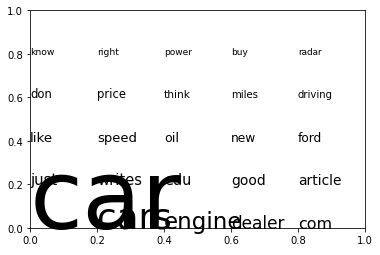

In [58]:
# Plotting a word cloud with Matplotlib
i = 0
for x_coord in np.arange(0, 1, .2):
  for y_coord in np.arange(0, 1, .2):
    word, significance = df_ranked_words.iloc[i].values
    plt.text(y_coord, x_coord, word, fontsize=2 * significance)
    i += 1
plt.show()

Our visualization is a mess! Large words like car take up too much space.

They overlap
with other words, making the image indecipherable. We need to plot our words much more intelligently.

Fortunately, the hard work has been done for us by
the creators of the external Wordcloud library.

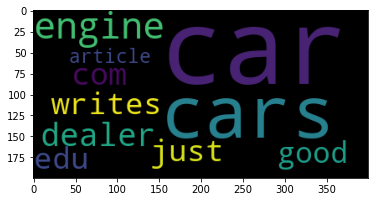

In [59]:
# Generating a word cloud image
cloud_generator = WordCloud(random_state=1)

words_to_score = {word: score for word, score in df_ranked_words[:10].values}
wordcloud_image = cloud_generator.fit_words(words_to_score)

plt.imshow(wordcloud_image)
plt.show()

Our visualization is not ideal: the dark background
makes it hard to read the words.

Let’s regenerate
the word cloud with a lighter background while also smoothing out the visualized
letters

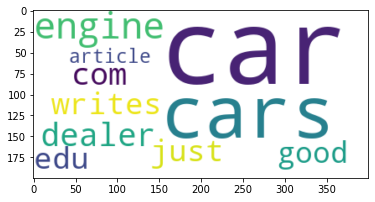

In [60]:
# Improving the word cloud image quality
cloud_generator = WordCloud(background_color="white", random_state=1)

wordcloud_image = cloud_generator.fit_words(words_to_score)

plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

The top words in the car cluster have been successfully visualized.

We can interpret the
contents of the cluster merely by glancing at the word cloud.

Let’s instead apply word cloud visualization to a randomly chosen
cluster.

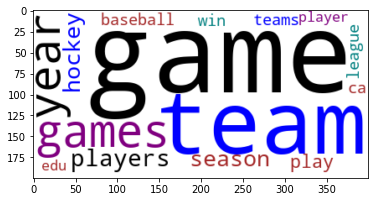

In [61]:
# Plotting a word cloud for a random cluster
np.random.seed(1)

def cluster_to_image(df_cluster, max_words=15):
  indices = df_cluster.Index.values
  df_ranked_words = rank_words_by_tfidf(indices)[:max_words]

  words_to_score = {word: score for word, score in df_ranked_words[:max_words].values}
  cloud_generator = WordCloud(background_color="white", color_func=_color_func, random_state=1)
  wordcloud_image = cloud_generator.fit_words(words_to_score)
  return wordcloud_image

def _color_func(*args, **kwargs):
  return np.random.choice(["black", "blue", "teal", "purple", "brown"])

cluster_id = np.random.randint(0, 20)
df_random_cluster = df[df.Cluster == cluster_id]
wordcloud_image = cluster_to_image(df_random_cluster)
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

We can verify by printing the most common newsgroup category in the
cluster.

In [62]:
# Checking the most common cluster category
def get_top_category(df_cluster):
  categories = [get_post_category(index) for index in df_cluster.Index.values]
  top_category, _ = Counter(categories).most_common()[0]
  return top_category

top_category = get_top_category(df_random_cluster)
print(f"The posts within the cluster commonly appear in the '{top_category}' newsgroup")

The posts within the cluster commonly appear in the 'rec.sport.hockey' newsgroup


We’ve thus successfully identified the cluster’s topic of hockey. We did this simply by
looking at the word cloud.

##Visualizing multiple word clouds

Matplotlib allows us to include multiple plots in a single figure. Each distinct plot is
called a subplot. 

Subplots can be organized in any number of ways, but they’re most
commonly arranged in a grid-like pattern.

Let’s demonstrate the use of `plt.subplots`.

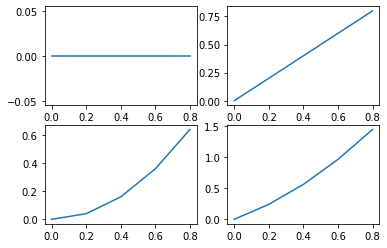

In [63]:
# Generating four subplots
figure, axes = plt.subplots(2, 2)
for r in range(2):
  for c in range(2):
    x = np.arange(0, 1, .2)
    y = r * x * x + c * x
    axes[r][c].plot(x, y)
plt.show()

Let’s visualize `wordcloud_image` in the lower-left quadrant.

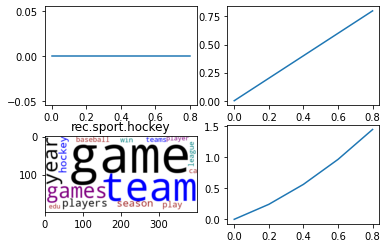

In [66]:
# Plotting a word cloud within a subplot
figure, axes = plt.subplots(2, 2)
for r in range(2):
  for c in range(2):
    if (r, c) == (1, 0):
      axes[r][c].set_title(top_category)
      axes[r][c].imshow(wordcloud_image, interpolation="bilinear")
    else:
      x = np.arange(0, 1, .2)
      y = r * x * x + c * x
    axes[r][c].plot(x, y)
plt.show()

The words in the cloud are hard to read because the subplot is so small.
We need to make the subplot bigger, which requires us to alter the figure size.

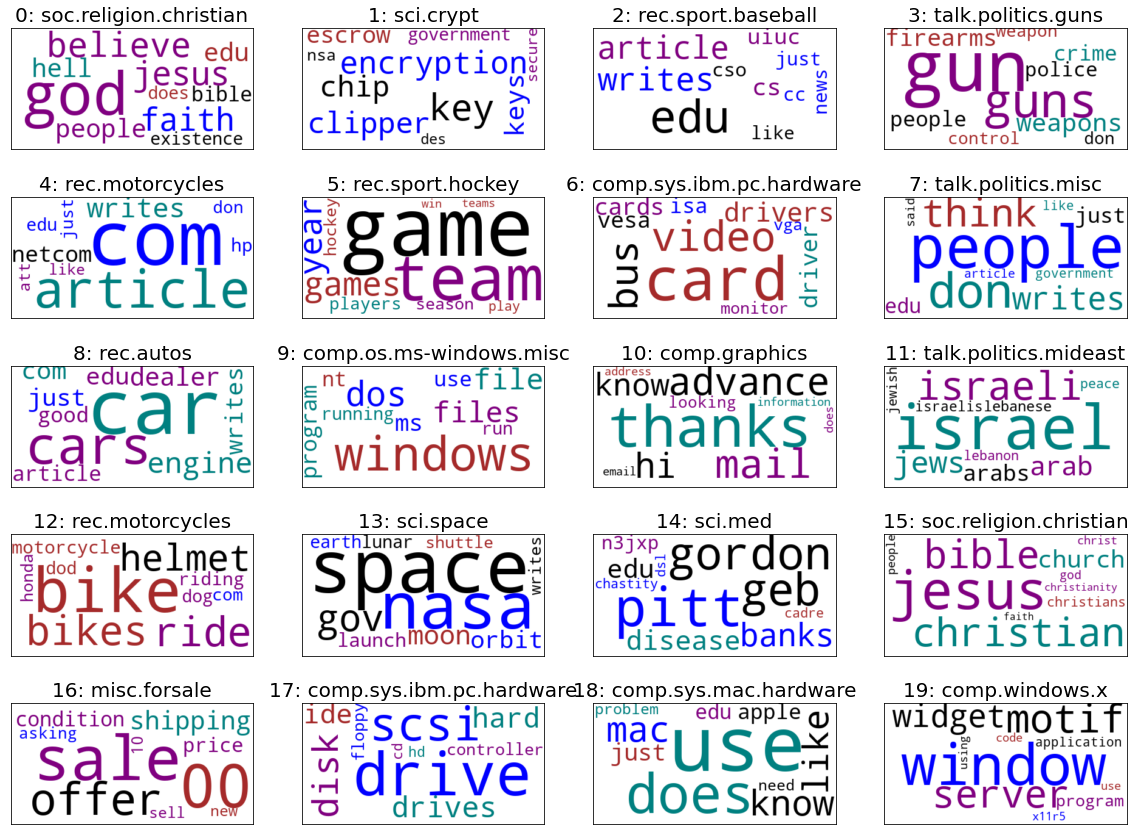

In [67]:
# Visualizing all clusters using 20 subplots
np.random.seed(0)

def get_title(df_cluster):
  top_category = get_top_category(df_cluster)
  cluster_id = df_cluster.Cluster.values[0]
  return f"{cluster_id}: {top_category}"

figure, axes = plt.subplots(5, 4, figsize=(20, 15))
cluster_groups = list(df.groupby("Cluster"))

for r in range(5):
  for c in range(4):
    _, df_cluster = cluster_groups.pop(0)
    wordcloud_image = cluster_to_image(df_cluster, max_words=10)

    ax = axes[r][c]
    ax.imshow(wordcloud_image, interpolation="bilinear")
    ax.set_title(get_title(df_cluster), fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Of course, there are issues with our output. Several of the word clouds do not
make sense.

Unfortunately, word cloud visualization isn’t always perfect. Sometimes
the underlying clusters are malformed, or the dominant language in the clusters is
biased toward unexpected text patterns.

Fortunately, there are steps we can take to salvage the indecipherable word clouds.

For instance, we can filter out obviously useless words and then regenerate the cloud.
Or we can simply disregard the top x words in the cluster and visualize the cloud using
the next top-ranking words. 

Let’s remove the top 10 words from cluster 2 and recompute
its word cloud.

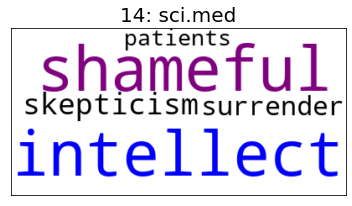

In [75]:
# Recomputing a word cloud after filtering
np.random.seed(3)

df_cluster = df[df.Cluster == 14]
df_ranked_words = rank_words_by_tfidf(df_cluster.Index.values)

words_to_score = {word: score for word, score in df_ranked_words[10: 15].values}

cloud_generator = WordCloud(background_color="white", color_func=_color_func, random_state=1)
wordcloud_image = cloud_generator.fit_words(words_to_score)
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.title(get_title(df_cluster), fontsize=20)
plt.xticks([])
plt.yticks([])

plt.show()

##Summary

Effectively, we’ve developed a pipeline for clustering
and visualizing unstructured text data. 

That pipeline works as follows:

1. Transform our text into a normalized TFIDF matrix using the TfidfVectorizer
class.
2. Reduce the matrix to 100 dimensions using the SVD algorithm.
3. Normalize the dimensionally reduced output for clustering purposes.
4. Cluster the normalized output using K-means. We can estimate K by generating
an elbow plot using mini-batch K-means, which is optimized for speed.
5. Visualize the top words in each cluster using a word cloud. All word clouds are displayed as subplots in a single figure. Words are ranked based on their summed TFIDF values across all the texts in a cluster.
6. Interpret the topic of each cluster using the word cloud visualization. Any uninterpretable clusters are examined in more detail.

Given our text-analysis pipeline, we can effectively cluster and interpret almost any real-world text dataset.